# INM701 Coursework
### Aaron Mir (Student Number: 160001207)

In this coursework, you are expected to demonstrate what you have learned in the module by applying artificial intelligence techniques as covered in the module to a dataset and domain of your choice. This will include some or all of:

    • Define the domain and dataset(s) (you are free to choose the domain and the dataset that you want to investigate).

    • Define  questions and analysis tasks (a brief overview  of  the  domain, analytical questions that are being asked, a list of your objectives and the 
    expected output(s)of your analysis)
    
    • Perform an initial investigation of the dataset and the characteristics of the data. Develop a viable plan: which  data  processing  steps  you  will  need  to
    perform, how you will transform the data to make it useable, which artificial intelligence techniques you can potentially use and what sorts of potential
    observations these can lead to.

    • Perform the analysis.  Get the data ready for analysis, carry out your analysis/modelling as  needed,  validate your  results  and  communicate observations, 
    iterating through this process. Analytical operations can include data processing to an extent that is needed (not all datasets are messy) to prepare a useful and
    robust dataset to work within, and data derivation (such as feature engineering).

    • Split your dataset (train/validate/test, somedatasets come pre-split). If you have a holdout test set then you most likely don’t want to use this until the near 
    the end of your work.

    • You might establish a baseline result first, computing metrics on training and validation sets,  analyse  errors, work  on  succeeding iterations, and 
    alternative models. (If initial metrics are amazing and there are no errors is the problem too easy?)

    • Be  close to your data  (visualise  the  dataset,  collect  summary  statistics,  look  at  errors, analyse how different parameters affect performance, try 
    out different model variants).


## Prediction of Atrial Fibrillation using a 1D Convolutional Neural Network
Goal: Use the Paroxysmal Atrial Fibrillation Prediction Challenge Database to build a model that can predict onset of Atrial Fibrillation (AF) from an Electrocardiogram (ECG) signal. This database contains a training set (with 50 30-minute two-lead ECGs of patients with Normal Sinus Rhythm (NSR/no signs of AF) and 50 30-minute two-lead ECGs of patients with Paroxysmal AF) and a testing set. The labels of the testing set are not known so in order to test the model, the training set will be split into training and testing sets. 

Extra goal: Use model on other databases


In [103]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import os
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow.keras.utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, MaxPool1D, Flatten
from tensorflow.python.client import device_lib


In [2]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"Tesorflow Version: {tensorflow.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")

Python: 3.8.1 (tags/v3.8.1:1b293b6, Dec 18 2019, 23:11:46) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.18.1
Tesorflow Version: 2.3.0
Keras Version: 2.4.0


## Data Processing

In [122]:
classification = ['NSR', 'AF']
train_folder =  'data/Train'          # data in csv format
numpy_data = 'data/Numpy_Data'        # will contain X_train and y_train data after conversion to np file 

In [125]:
# Each ECG file has 7680 data points and two-leads so two columns per lead and 100 ECG files in total but we want to segment this in order to feed more easily into the model
def load_label_segment(location): 
    X = []
    y = []
    for i in classification:                                    # iterate through each type of classification
        for data in os.listdir(location + i):
            df = pd.read_csv(location + i + '\\' + data)        # load the CSV for each file per each classification
            df.drop(index=0, axis=0, inplace=True)              # get rid of the first row, which contains the units of measurement
            df.columns = ["time", "ECG0", "ECG1"]               # rename the columns for easy access
            df.drop(['time'], axis=1, inplace=True)             # get rid of time column, as we do not need to use it as a time series
            df.ECG0 = pd.to_numeric(df.ECG0)                    # convert each row into numbers
            df.ECG1 = pd.to_numeric(df.ECG1)
            split = np.array_split(df, 30)                       
            for array in split:
                X.append(np.array(array)) 
                if i == 'NSR':
                    y.append(0)
                if i == 'AF':
                    y.append(1)                  
    return np.array(X), np.expand_dims(np.array(y), axis=1)    

In [126]:
# Load the training data
X_train, y_train = load_label_segment(train_folder)
print(X_train.shape, y_train.shape)

(3000, 256, 2) (3000, 1)


In [127]:
np.save('data/Numpy_Data/X_train.npy', X_train) # saving the training data as np files for easy access
np.save('data/Numpy_Data/y_train.npy', y_train)

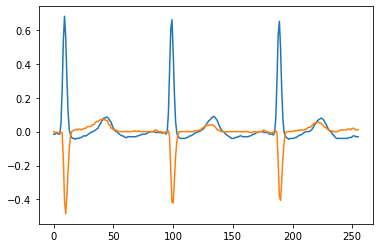

In [128]:
plt.plot(X_train[0])

## 1D Convolutional Neural Network Model

In [4]:
print(device_lib.list_local_devices()) # GPU available for training the model, IT IS RECOMMENDED TO USE GPU

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7602151463977454281
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1816256244879269706
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6579684390
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3045512399939374413
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5398960838104707851
physical_device_desc: "device: XLA_GPU device"
]


In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=30)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2100, 256, 2) (2100, 1)
(900, 256, 2) (900, 1)


In [116]:
model = Sequential()
model.add(Conv1D(filters=512, kernel_size=32, padding = 'same', kernel_initializer='normal', activation='relu', input_shape=(192, 2)))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=512, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=256, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=5, padding = 'same', kernel_initializer='normal', activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=128, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

ValueError: Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling1d_41/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](max_pooling1d_41/ExpandDims)' with input shapes: [?,1,1,64].

## Other Model